This demo is modified from https://www.datacamp.com/community/tutorials/autoencoder-classifier-python

The datasets are available at https://github.com/zalandoresearch/fashion-mnist

In [8]:
# enable this if you have a GPU

# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

# Alternatively, enable free google colab CPU: in the menu, choose Runtime / Change runtime type / Hardware accelerator / GPU
# this decreases epoch training time from 180 s to 2 s
# ** if you use too much google GPU, they will ask you to sign up for the paid version of Colab

Preamble

In [9]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from tensorflow.keras.utils import to_categorical

In [10]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [11]:
train_data = extract_data('train-images-idx3-ubyte.gz', 10000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',10000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

Data Understanding

In [12]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (10000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [13]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: E)')

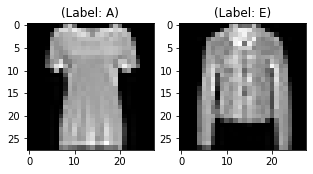

In [14]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")



Data preparation - reshape and normalize

In [15]:
train_data.shape, test_data.shape

train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

# it was
# Training set (images) shape: (10000, 28, 28)
# Test set (images) shape: (10000, 28, 28)

((10000, 28, 28, 1), (10000, 28, 28, 1))

In [16]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [17]:
# "normalize"

np.max(train_data), np.max(test_data)
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

np.max(train_data), np.max(test_data)

(1.0, 1.0)

Data preparation - split the dataset

In [18]:
# gold standard

from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

Autoencoder

In [19]:
batch_size = 64
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [20]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [21]:
# we defined Model as "from keras.models import Model"

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

Train AE

In [22]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/50
125/125 [==============================] - 21s 17ms/step - loss: 0.0433 - val_loss: 0.1129
Epoch 2/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0220 - val_loss: 0.0909
Epoch 3/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0168 - val_loss: 0.0197
Epoch 4/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0138 - val_loss: 0.0195
Epoch 5/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 6/50
125/125 [==============================] - 2s 15ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 7/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 8/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0094 - val_loss: 0.0206
Epoch 9/50
125/125 [==============================] - 2s 15ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 10/50
125/125 [==============================] - 2s 14ms/step - loss: 0.0090 - val_l

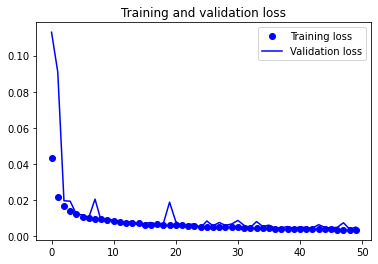

In [23]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
autoencoder.save_weights('autoencoder.h5')

one-hot for labels

In [25]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [26]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)


In [27]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape


((8000, 28, 28, 1), (2000, 28, 28, 1), (8000, 10), (2000, 10))

Discard decoder and build new model

In [28]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

FC layers

In [29]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out


encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

Copy the encoder to the new model & verify

In [30]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [31]:
autoencoder.get_weights()[0][1]

array([[[ 0.08505409,  0.13602518,  0.00143683,  0.07001637,
          0.24312072, -0.09432301,  0.07159704,  0.17577612,
         -0.10018145,  0.22851554,  0.07060923, -0.12158126,
         -0.18056917,  0.00570163, -0.20963778,  0.04295082,
          0.08911286,  0.14459305, -0.15725271, -0.04001632,
          0.06798534, -0.19877021, -0.00977438,  0.12414701,
          0.01998182, -0.14268509,  0.134868  ,  0.06431331,
         -0.12447225,  0.15859264,  0.09603851,  0.12631053]],

       [[ 0.08796773, -0.06342781,  0.03274878,  0.10672624,
         -0.05314717, -0.11901394, -0.02760253,  0.17895906,
          0.05565858, -0.01669496,  0.09029219,  0.05444503,
         -0.16523366, -0.05297687, -0.11596847,  0.18671997,
         -0.16506623, -0.13275887,  0.0081088 ,  0.1976141 ,
         -0.03618211, -0.2679207 , -0.20124927,  0.13280015,
          0.19992642,  0.12126735,  0.09301068,  0.19825862,
         -0.13333689,  0.12656094,  0.11781883,  0.07415241]],

       [[-0.173827

In [32]:
full_model.get_weights()[0][1]

array([[[ 0.08505409,  0.13602518,  0.00143683,  0.07001637,
          0.24312072, -0.09432301,  0.07159704,  0.17577612,
         -0.10018145,  0.22851554,  0.07060923, -0.12158126,
         -0.18056917,  0.00570163, -0.20963778,  0.04295082,
          0.08911286,  0.14459305, -0.15725271, -0.04001632,
          0.06798534, -0.19877021, -0.00977438,  0.12414701,
          0.01998182, -0.14268509,  0.134868  ,  0.06431331,
         -0.12447225,  0.15859264,  0.09603851,  0.12631053]],

       [[ 0.08796773, -0.06342781,  0.03274878,  0.10672624,
         -0.05314717, -0.11901394, -0.02760253,  0.17895906,
          0.05565858, -0.01669496,  0.09029219,  0.05444503,
         -0.16523366, -0.05297687, -0.11596847,  0.18671997,
         -0.16506623, -0.13275887,  0.0081088 ,  0.1976141 ,
         -0.03618211, -0.2679207 , -0.20124927,  0.13280015,
          0.19992642,  0.12126735,  0.09301068,  0.19825862,
         -0.13333689,  0.12656094,  0.11781883,  0.07415241]],

       [[-0.173827

Set the encoder part of the model as "read-only"

In [33]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [38]:
import tensorflow
my_optimizer = tensorflow.keras.optimizers.Adam()
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=my_optimizer,metrics=['accuracy'])


In [39]:
full_model.summary()
full_model.save_weights('autoencoder_classification.h5')


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0   

Train model

In [40]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=35,verbose=1,validation_data=(valid_X, valid_label))


Epoch 1/35
125/125 [==============================] - 2s 7ms/step - loss: 0.6225 - accuracy: 0.8145 - val_loss: 0.4093 - val_accuracy: 0.8495
Epoch 2/35
125/125 [==============================] - 1s 5ms/step - loss: 0.2566 - accuracy: 0.9068 - val_loss: 0.4659 - val_accuracy: 0.8440
Epoch 3/35
125/125 [==============================] - 1s 5ms/step - loss: 0.1748 - accuracy: 0.9349 - val_loss: 0.4971 - val_accuracy: 0.8645
Epoch 4/35
125/125 [==============================] - 1s 5ms/step - loss: 0.1083 - accuracy: 0.9595 - val_loss: 0.4725 - val_accuracy: 0.8585
Epoch 5/35
125/125 [==============================] - 1s 5ms/step - loss: 0.0820 - accuracy: 0.9721 - val_loss: 0.5071 - val_accuracy: 0.8650
Epoch 6/35
125/125 [==============================] - 1s 5ms/step - loss: 0.0605 - accuracy: 0.9799 - val_loss: 0.5564 - val_accuracy: 0.8590
Epoch 7/35
125/125 [==============================] - 1s 5ms/step - loss: 0.0295 - accuracy: 0.9916 - val_loss: 0.5585 - val_accuracy: 0.8725
Epoch 

Evaluate

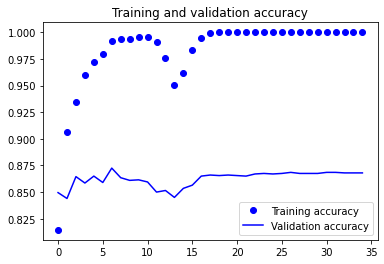

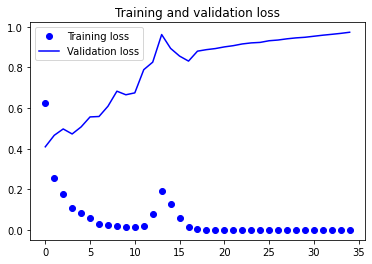

In [41]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Make 1st 19 layers trainable & retrain (unsure as to why, commented out)

In [42]:
# for layer in full_model.layers[0:19]:
#     layer.trainable = True

# full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

# classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))


Eval on test set

In [43]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

predicted_classes = full_model.predict(test_data)

Test loss: 0.899391233921051
Test accuracy: 0.8755000233650208


Found 8753 correct labels


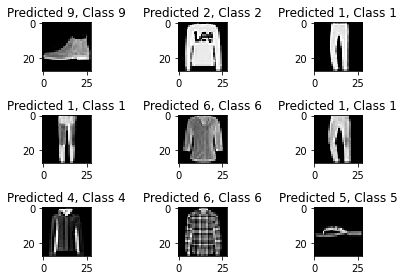

In [44]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape

correct = np.where(predicted_classes==test_labels)[0]

num_correct=len(correct)

print(f"Found {num_correct} correct labels")

for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 1247 incorrect labels


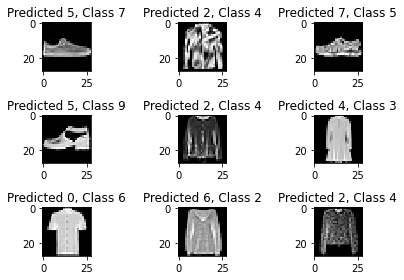

In [45]:
incorrect = np.where(predicted_classes!=test_labels)[0]
num_incorrect=len(incorrect)

print(f"Found {num_incorrect} incorrect labels")

for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))